In [1]:
import io
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import torch
import torch.nn as nn
from transformers import AutoImageProcessor, ViTForImageClassification, Trainer, TrainingArguments
from datasets import Dataset, Image, ClassLabel
import evaluate
from transformers import TrainerCallback
import wandb

wandb.login()
wandb.init(project="ViT-HyperSweep_test", name="run_2")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: cebangu (megdecoding) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [2]:
label_path = os.path.join(os.getcwd(), "scalograms_test/average_labels.csv")
image_path = os.path.join(os.getcwd(), "scalograms_test/images_average")
df = pd.read_csv(label_path)
df['image'] = df['FileName'].apply(lambda x: os.path.join(image_path, x))
df["label"] = df["Label"].astype("category")
df = df.drop(columns=["Label", "FileName"])
unique_labels = set(df["label"])
class_label = ClassLabel(names=list(unique_labels))

In [3]:
dataset = Dataset.from_pandas(df).cast_column("image", Image())
dataset = dataset.cast_column("label", class_label)


Casting the dataset:   0%|          | 0/324 [00:00<?, ? examples/s]

In [4]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 324
})

In [4]:
processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224", use_fast=True)
processor.size = {"height" : 384, "width" : 384}

In [5]:
def transform_for_model(example):
    example['pixel_values'] = [image.convert("RGB") for image in example['image']]
    example['pixel_values'] = processor(example['pixel_values'], return_tensors='pt')["pixel_values"]
    return example

dataset = dataset.map(transform_for_model, batched=True)

Map:   0%|          | 0/324 [00:00<?, ? examples/s]

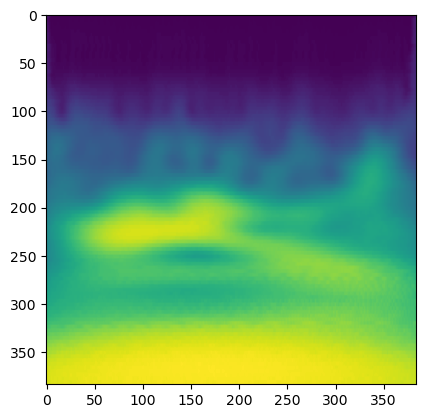

In [19]:
plt.imshow(dataset['pixel_values'][0][1])

In [6]:
dataset = dataset.train_test_split(test_size=0.1, stratify_by_column="label", seed=42)

### Ok it's probably best to just wrap the model in a custom class

The original model is trained on 224x224, but the best practices are to finetune of 384x384. So we need to at least interpolate the positional encodings. 

In [7]:
class MEGVisionTransformer(ViTForImageClassification):
    """Custom VIT wrapper that makes sure the positional encodings are interpolated"""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs) # parent init

    def forward(self, pixel_values=None, labels=None, **kwargs):
        return super().forward(
            pixel_values=pixel_values,
            labels=labels,
            interpolate_pos_encoding=True,
            **kwargs
        )
    
    def freeze_layer(self, freeze_type=None):
        if freeze_type not in["classifier", "attention"]:
            raise ValueError('freeze_type is either classifier or attention')

        if freeze_type == "classifier":
            self.classifier_only()
        elif freeze_type == "attention":
            self.mha_training()
    
    ### layer freezing methods
    def classifier_only(self):
        for name, param in self.named_parameters():
            # Unfreeze if the parameter belongs to the classifier or an attention layer.
            if "classifier" in name:
              param.requires_grad = True
              print(f"Unfreezing {name}")
            else:
                param.requires_grad = False
                print(f"Freezing {name}")

    def mha_training(self):
        for name, param in self.named_parameters():
            # Unfreeze if the parameter belongs to the classifier or an attention layer.
            if "classifier" in name or "attention" in name:
                param.requires_grad = True
                print(f"Unfreezing {name}")
            else:
                param.requires_grad = False
                print(f"Freezing {name}")

In [8]:
model_checkpoint = "google/vit-base-patch16-224"
num_classes = len(unique_labels)
model = MEGVisionTransformer.from_pretrained(
    model_checkpoint,
    ignore_mismatched_sizes=True,
    num_labels=num_classes
)

Some weights of MEGVisionTransformer were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Which parameters to fine-tune? Well, Touvron et al say to fine tune the MHA layers

In [9]:
model.freeze_layer("attention")

Freezing vit.embeddings.cls_token
Freezing vit.embeddings.position_embeddings
Freezing vit.embeddings.patch_embeddings.projection.weight
Freezing vit.embeddings.patch_embeddings.projection.bias
Unfreezing vit.encoder.layer.0.attention.attention.query.weight
Unfreezing vit.encoder.layer.0.attention.attention.query.bias
Unfreezing vit.encoder.layer.0.attention.attention.key.weight
Unfreezing vit.encoder.layer.0.attention.attention.key.bias
Unfreezing vit.encoder.layer.0.attention.attention.value.weight
Unfreezing vit.encoder.layer.0.attention.attention.value.bias
Unfreezing vit.encoder.layer.0.attention.output.dense.weight
Unfreezing vit.encoder.layer.0.attention.output.dense.bias
Freezing vit.encoder.layer.0.intermediate.dense.weight
Freezing vit.encoder.layer.0.intermediate.dense.bias
Freezing vit.encoder.layer.0.output.dense.weight
Freezing vit.encoder.layer.0.output.dense.bias
Freezing vit.encoder.layer.0.layernorm_before.weight
Freezing vit.encoder.layer.0.layernorm_before.bias
Free

In [10]:
num_params = sum([p.numel() for p in model.parameters()])
trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])

print(f"{num_params = :,} | {trainable_params = :,}")

num_params = 85,800,963 | trainable_params = 28,350,723


In [11]:
# different metrics
from sklearn.metrics import confusion_matrix

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1) #logits to class
    accuracy = accuracy_metric.compute(predictions=predictions, 
                                       references=labels)
    f1 = f1_metric.compute(predictions=predictions, 
                           references=labels, 
                           average='weighted'
                           )
    precision = precision_metric.compute(predictions=predictions, 
                                         references=labels, 
                                         average='weighted',
                                         zero_division=0.0 #control null predicition
                                         )
    recall = recall_metric.compute(predictions=predictions, 
                                   references=labels, 
                                   average='weighted'
                                   )

    # specificity we will have to compute manuall unfortunately
    cm = confusion_matrix(labels, predictions, labels=[0, 1, 2]) # classes remember to change this!

    num_classes = cm.shape[0]
    specificity_per_class = []
    
    for i in range(3): #num classes
        # true negatives
        TN = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i]) 
        FP = np.sum(cm[:, i]) - cm[i, i]

        # compute specificity for each class and avoid dividing by 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificity_per_class.append(specificity)
    
    avg_specificity = np.mean(specificity_per_class)

    wandb.log({
        "accuracy": accuracy["accuracy"],
        "f1": f1["f1"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "specificity": specificity,
    })

    return {
        "accuracy": accuracy["accuracy"],
        "f1": f1["f1"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "specificity": specificity,
    }

In [12]:
def collate_fn(examples):
    pixel_values = torch.stack([torch.tensor(example["pixel_values"]) for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:


args = TrainingArguments(
    f"{model_name}-finetune_test",
    seed=42,
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=1, 
    num_train_epochs=50,
    warmup_ratio=0.1,
    logging_steps=10,
    metric_for_best_model='f1',
    report_to="wandb",
    push_to_hub=False,
)


In [14]:
trainer = Trainer(
    model,
    args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

We need to do a sweep, so let's try this out 

In [14]:
model_name = model_checkpoint.split("/")[-1]

sweep_config = {
    "method": "bayes",
    "metric": {"name": "avg_eval_loss", "goal": "minimize"}, # we want to optimize the average eval loss accross folds
    "parameters": {
        "learning_rate": {"values": [1e-5, 3e-5, 5e-5, 1e-4]}, # sweep learning rates (we'll see how many we can do)
        "lr_scheduler_type": {"values": ["linear", "cosine", "constant"]},
        "optim": {"values": ["adamw_torch", "adamw_hf", "adafactor"]}, # have to consider this some more
        "gradient_accumulation_steps": {"values": [1, 4, 8]}, # does this really matter?
        },
        "early_terminate": {
            "type": "hyperband", # stop runs early
            "min_iter": 15,
        }
}

In [15]:
from sklearn.model_selection import KFold
def cross_validate_kfol(train_dataset, model, config=None, k=10):
    """Train dataset has to be dataset["train"]"""
    
    with wandb.init(config=config):
        kf = KFold(n_splits=k, shuffle=True)
        fold_results = []

        for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
            print(f"Training Fold {fold + 1}/{k}...")

            # splitting into train and val
            train_subset = train_dataset.select(train_idx.tolist())
            val_subset = train_dataset.select(val_idx.tolist())

            training_args = TrainingArguments(
                f"{model_name}-finetune_test",
                seed=42,
                remove_unused_columns=False,
                eval_strategy="epoch",
                save_strategy="epoch",
                learning_rate=config.learning_rate, # take it from the wandb config
                lr_scheduler_type=config.lr_scheduler_type, # take from config
                optim=config.optim, # tune optimizer
                gradient_accumulation_steps=config.gradient_accumulation_steps, #tune gradient accumulation
                per_device_train_batch_size=1,
                per_device_eval_batch_size=1, 
                num_train_epochs=50,
                warmup_ratio=0.1,
                logging_steps=10,
                metric_for_best_model='eval_loss',
                report_to="wandb",
                push_to_hub=False,
            )

            trainer = Trainer(
                model=model, 
                args=training_args,
                train_dataset=train_subset,
                eval_dataset=val_subset,
            )
            
            trainer.train()
            eval_results = trainer.evaluate()

            fold_results.append(eval_results["eval_loss"]) # is this really what we want to track?
            wandb.log({f"fold_{fold+1}_eval_loss": eval_results["eval_loss"]})

        avg_eval_loss=np.mean(fold_results)
        wandb.log({"avg_eval_loss": avg_eval_loss})

    wandb.finish()

In [16]:
sweep_id = wandb.sweep(sweep_config, project="VIT-KFold-HyperSweep")
wandb.agent(sweep_id, lambda: cross_validate_kfol(train_dataset=dataset['train'], model=model), count=10)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: hez6h95w
Sweep URL: https://wandb.ai/megdecoding/VIT-KFold-HyperSweep/sweeps/hez6h95w


wandb: Agent Starting Run: 2od5qzze with config:
wandb: 	gradient_accumulation_steps: 4
wandb: 	learning_rate: 1e-05
wandb: 	lr_scheduler_type: cosine
wandb: 	optim: adamw_hf


wandb: 
wandb: 🚀 View run run_2 at: https://wandb.ai/megdecoding/ViT-HyperSweep_test/runs/5pgchwym
wandb: Find logs at: wandb/run-20250226_175033-5pgchwym/logs


Exception in thread Thread-8 (_run_job):
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniconda/base/envs/neuroai/lib/python3.12/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/f1/tvmmnqs17399g3n7wyy0pq0c0000gn/T/ipykernel_95499/3057570896.py", line 2, in <lambda>
  File "/var/folders/f1/tvmmnqs17399g3n7wyy0pq0c0000gn/T/ipykernel_95499/3858686972.py", line 5, in cross_validate_kfol
  File "/opt/homebrew/Caskroom/miniconda/base/envs/neuroai/lib/python3.12/site-packages/wandb/sdk/wandb_init.py", line 1485, in init
    wandb._sentry.reraise(e)
  File "/opt/homebrew/Caskroom/miniconda/base/envs/neuroai/lib/python3.12/site-packages/wandb/analytics/sentry.py", line 156, in reraise
    raise exc.with_traceback(sys.exc_info()[2])
  File "/opt/homebrew/Caskroom/miniconda/base/envs/neuroai/lib/python3.12/site-packages/wandb/sdk/wandb_init.py", line 1471, in init
    return wi.init(run_settings, run_config)
           ^^

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x321049d30>> (for post_run_cell), with arguments args (<ExecutionResult object at 3221e0ce0, execution_count=16 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 3221e0b30, raw_cell="sweep_id = wandb.sweep(sweep_config, project="VIT-.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/Volumes/BCOM/ciprian_project/MEG-Decoding/ViT_adaptation.ipynb#X61sZmlsZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe